# MNIST classification

**Course:** 02506 Advanced Image Analysis Spring 21

**Authors:**  Allan Erlang Videbæk (s164197), Mads Emil Dahlgaard (s164206) and Niels Asp Nielsen (s164181).

***

## Explanation of project
This notebook serves as a demonstration of the trained MNIST classifier. Run this notebook to get classification results on previously unseen data.

### Code structure

The only used 3rd party libraries are NumPy and Matplotlib.
```
.
├── mnist                   # MNIST data.
├── models                  # Trained models saved as pickles.
├── nn.py                   # Code for Neural Network.
├── augmentation.py         # Code for augmenting the MNIST dataset.
├── helpers.py              # Helper functions for data handling.
├── demonstration.ipynb     # Notebook for hand in and evaluation on test set.
├── .gitignore
└── README.md
```

### Augmentation

We use data augmentation in order to expand the training set and add diversity. We expect that this will increase the model's ability to generalize. 

For data augmentation we use
- Additive (Gaussian) noise.
- Rotation between -25 and 25 degrees.
- Mirroring and 180 degrees rotation (only of 0 and 8).

### Preprocessing

We tested out deskewing. We tried with and without deskewing and it turned out to improve the results quite a lot when using deskewing. Deskewing is basically an affine transformation. The image is offset by the center of mass of the image and the covariance matrix of the image is used to estimate the skew.

### Model selection

The experiments are run on the HPC cluster on a Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz.

The data set is split into a training set of 48000 images and a validation set of 12000 images. The best model is selected as the model performing best on the test set.

All models are trained using 200 epochs and a batch size of 200. The experiments are shown in the table below.

| Architecture | Hyper params | Augmentation | Preprocessing | Validation set accuracy |
| :--- | :--- | :--- | :--- | ---: |
| MLP [784, 400, 200, 10] | [$\eta$=0.001, $\gamma$=0.0]  | No | No | .942 |
| MLP [784, 400, 200, 10] | [$\eta$=0.001, $\gamma$=0.5]  | No | No | .966 |
| MLP [784, 400, 200, 10] | [$\eta$=0.001, $\gamma$=0.9]  | No | No | .971 |
| MLP [784, 800, 10] | [$\eta$=0.001, $\gamma$=0.9] | No | No | .972 |
| MLP [784, 400, 200, 10] | [$\eta$=0.001, $\gamma$=0.9] | Yes | No | .977|
| MLP [784, 500, 300, 10] | [$\eta$=0.001, $\gamma$=0.9]  | Yes | No | .979 |
| MLP [784, 800, 10] | [$\eta$=0.001, $\gamma$=0.9] | Yes | No | .979 |
| MLP [784, 800, 10] | [$\eta$=0.001, $\gamma$=0.9] | No | Yes | .979 |
| MLP [784, 800, 10] | [$\eta$=0.001, $\gamma$=0.9] | Yes | Deskewing | .985 |
| MLP [784, 500, 300, 10] | [$\eta$=0.001, $\gamma$=0.9] | Yes | Deskewing | .986 |

We choose the best model based on the validation set accuracy from the above table and retrain the model on the entire dataset of 60000 images.

***

## Evaluating on unseen data

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from helpers import read_mnist, format_data, load_nn

from deskew import deskew_all

### Load data and neural network model

Specify paths to the data below. By default these are set to the 10k test images.

In [2]:
im_path = 'mnist/t10k-images-idx3-ubyte'
lab_path = 'mnist/t10k-labels-idx1-ubyte'
ims, labels, a, t = read_mnist(im_path, lab_path)
# Format X as (n_obs, n_features) and onehot encode y.
X, y = format_data(ims, labels)

In [3]:
print(f"Shape of X: {X.shape}, shape of y: {y.shape}")

Shape of X: (10000, 784), shape of y: (10000, 10)


In [8]:
# Load neural network model.
nn = load_nn('models/deskew_0.979.pkl')

In [9]:
print(f"The neural network has {nn.num_layers} layers.")
for i, num_units in enumerate(nn.layers):
    print(f"Layer {i} has {num_units} units.")
print(f"The learning rate of the network during training is {nn.lr}.")
if nn.momentum>0:
    print(f"The neural network used momentum of {nn.momentum} during training.")

The neural network has 3 layers.
Layer 0 has 784 units.
Layer 1 has 800 units.
Layer 2 has 10 units.
The learning rate of the network during training is 0.001.
The neural network used momentum of 0.9 during training.


### Run and evaluate model on the data

In [10]:
X = deskew_all(X)
yhat, _, _ = nn.forward(X)
pred_labels = np.argmax(yhat,axis=1)

In [11]:
print(f"The classification accuracy is {np.mean(pred_labels==labels)}.")

The classification accuracy is 0.9835.


***

## Investigating the misclassifications

In [8]:
# Get missclassifications.
misses = pred_labels!=labels
miss_preds = pred_labels[misses]
miss_labels = labels[misses]
miss_ims = ims[misses]

In [9]:
print(f"Total misclassifications: {len(miss_labels)}")
for i in range(10):
    print(f"Misclassifications with true label {i}: {np.sum(miss_labels==i)}.")

Total misclassifications: 122
Misclassifications with true label 0: 8.
Misclassifications with true label 1: 6.
Misclassifications with true label 2: 18.
Misclassifications with true label 3: 14.
Misclassifications with true label 4: 7.
Misclassifications with true label 5: 16.
Misclassifications with true label 6: 11.
Misclassifications with true label 7: 15.
Misclassifications with true label 8: 10.
Misclassifications with true label 9: 17.


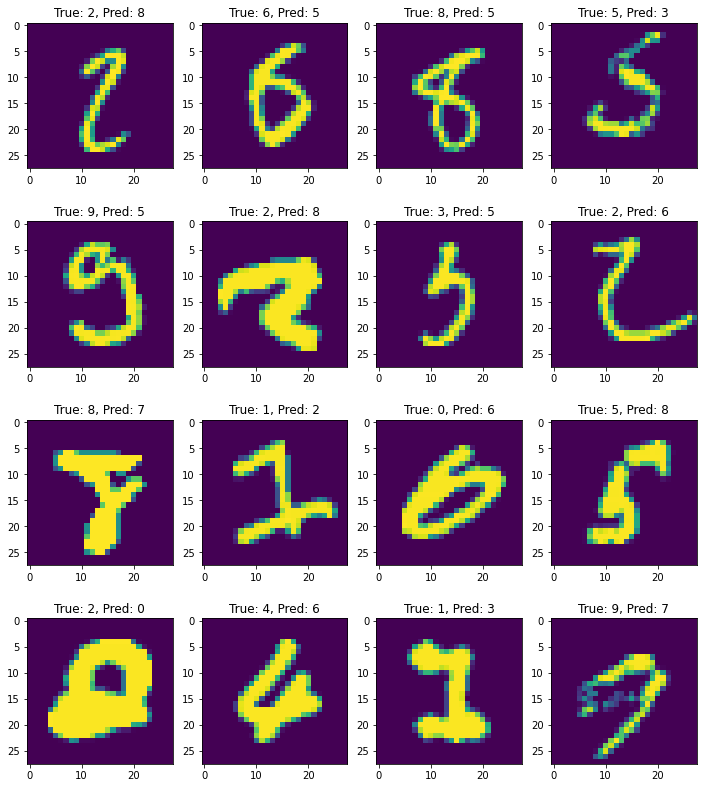

In [11]:
fig, ax = plt.subplots(4,4,figsize=(12,14)) 
ax = ax.ravel()
idxs = np.random.permutation(miss_ims.shape[0])

if len(idxs) < 16:
    print("Less than 16 misclassifications.")
else:
    for i in range(16):
        idx = idxs[i]
        ax[i].imshow(miss_ims[idx])
        ax[i].set_title(f'True: {miss_labels[idx]}, Pred: {miss_preds[idx]}')
    plt.show()

# TODO
- Show images of augmentation
- Mention we use momentum
- Remove all numbers from cells
- Clean up github
- Save best model in models

model overview (delete before handing in)
- final_1h_aug: 0.9831
- final_2h_aug: 0.9842
- final_1h_deskew_aug: 0.9868
- final_2h_deskew_aug: 0.9878
- final_2h_big_deskew_aug: 0.9879
